In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from math import pi
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns
sns.set_theme(style="white", context="talk")

import iqplot
import bokeh.io
from bokeh.layouts import column, gridplot
from bokeh.models import ColorBar, ColorMapper, LinearColorMapper, Ticker
bokeh.io.output_notebook()

import sgd_utils as sgd
import random
import seaborn as sb
# import mplcursors


Loading BokehJS ...

In [4]:
%load_ext blackcellmagic

In [5]:
def get_top_pop_movie_data(data, movies, topn):
    """Get the top rated movie ratings"""
    data_lists = []
    movie_count = get_pop_movie(data, movies)
    for i in movie_count.MOVIE_ID[:topn]:
        data_lists.append(data[data.MOVIE == i])
    return merge_title(pd.concat(data_lists), movies)


def get_pop_movie(data, movies):
    """Get the number and title of rated movies"""
    movie_count = pd.DataFrame(data.MOVIE.value_counts()).reset_index()
    movie_count.columns = ["MOVIE_ID", "RATING_COUNTS"]
    return movie_count

def get_topn_rate(data, movies, topn):
    """Get the top rated movies with each rating"""
    top_rate = get_top_rate(data, movies)
    
    df_list = []
    
    for i in top_rate.MOVIE[:topn]:
        df_list.append(data[data.MOVIE==i])
    
    return merge_title(pd.concat(df_list), movies)

def get_top_rate(data, movies):
    """Sort by top avg rating"""
    return (
        data.set_index(["MOVIE"])
        .groupby(["MOVIE"])
        .mean()
        .sort_values(["RATING"], ascending=False)
        .reset_index()
    )

def merge_title(df, movies, ifgenres=False):
    """Add movie titles"""
    if "MOVIE" in df.columns:
        df = df.rename(columns={"MOVIE": "MOVIE_ID"})
    if not ifgenres:
        movie_comb = movies.iloc[:, :2]
    else:
        movie_comb = movies

    df = df.merge(movie_comb, left_on="MOVIE_ID", right_on="MOVIE_ID", how="left")

    df.loc[df.TITLE.isnull(), "TITLE"] = (
        "MOVIE_ID: " + df.loc[df.TITLE.isnull(), "MOVIE_ID"]
    )

    return df

In [6]:
def load_train_test(trainortest):
    """Load train or test data"""
    return pd.read_csv(
        "https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project2/data/"
        + trainortest,
        sep="\t",
        header=None,
        names=["USER", "MOVIE", "RATING"],
    )


def load_data(f_data, f_train, f_test, f_movies):
    """Load the user and movie data, FZL modified"""

    data = load_train_test(f_data)
    train = load_train_test(f_train)
    test = load_train_test(f_test)

    movies = pd.read_csv(
        "https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project2/data/"
        + f_movies,
        encoding="latin-1",
        sep="\t",
        header=None,
        names=[
            "MOVIE_ID",
            "TITLE",
            "UNKNOWN",
            "ACTION",
            "ADVENTURE",
            "ANIMATION",
            "CHILDREN",
            "COMEDY",
            "CRIME",
            "DOCUMENTARY",
            "DRAMA",
            "FANTASY",
            "FILM-NOIR",
            "HORROR",
            "MUSICAL",
            "MYSTERY",
            "ROMANCE",
            "SCI-FI",
            "THRILLER",
            "WAR",
            "WESTERN",
        ],
    )

    movies.loc[movies.TITLE == "unknown", "TITLE"] = "MOVIE_ID: " + movies.loc[
        movies.TITLE == "unknown", "MOVIE_ID"
    ].astype("str")

    return data, train, test, movies

In [7]:

def check_dup(df, df_details):
    """Check fi there are duplicated entries for each dataframe"""
    print(f"There are {sum((df.duplicated())*1)} duplicate entires in {df_details}")

In [8]:
data, Y_train_df, Y_test_df, movies = load_data(
    "data.txt", "train.txt", "test.txt", "movies.txt"
)


## Matrix Factorization visualizations
### Method 1: HW5 solution

In [9]:
def get_MNY(Y_train_df, Y_test_df):
    """Return Y_train, Y_test, M, N, 
    where M is unique user IDs and N is unique movie IDs"""
    return (
        Y_train_df.to_numpy(),
        Y_test_df.to_numpy(),
        int(max(max(Y_train_df.USER), max(Y_test_df.USER))),
        int(max(max(Y_train_df.MOVIE), max(Y_test_df.MOVIE))),
    )

In [8]:
Y_train, Y_test, M, N = get_MNY(Y_train_df, Y_test_df)

print("Factorizing with ", M, " users, ", N, " movies.")
Ks = 20

reg = 0.0
eta = 0.03  # learning rate
E_in = []
E_out = []

# Use to compute Ein and Eout
U, V, err_training = sgd.train_model(M, N, Ks, eta, reg, Y_train)
print("Err training", err_training)
print("Err testing", sgd.get_err(U, V, Y_test))
print("dim U [m x k]", U.shape)
print("dim V [k x n]", V.shape)

Factorizing with  943  users,  1682  movies.
Epoch 1, E_in (regularized MSE): 0.5207409521962593
Epoch 2, E_in (regularized MSE): 0.397324175115462
Epoch 3, E_in (regularized MSE): 0.3549338274589559
Epoch 4, E_in (regularized MSE): 0.3247931855696651
Epoch 5, E_in (regularized MSE): 0.310530577307572
Epoch 6, E_in (regularized MSE): 0.2985793070586949
Epoch 7, E_in (regularized MSE): 0.282540621193733
Epoch 8, E_in (regularized MSE): 0.2756218677561639
Epoch 9, E_in (regularized MSE): 0.2666201094313112
Epoch 10, E_in (regularized MSE): 0.2626761661695382
Epoch 11, E_in (regularized MSE): 0.2594009135425386
Epoch 12, E_in (regularized MSE): 0.25544874748619373
Epoch 13, E_in (regularized MSE): 0.25418559855028333
Epoch 14, E_in (regularized MSE): 0.24905191112718086
Epoch 15, E_in (regularized MSE): 0.2486494605344067
Err training 0.2486494605344067
Err testing 0.663304813897297
dim U [m x k] (943, 20)
dim V [k x n] (20, 1682)


In [9]:
## SVD

def get_first_two_components_from_svd(V):
    A, sigma, B = np.linalg.svd(V, full_matrices=False)
    A_two_cols = A[:, 0:2]
    return A_two_cols

A_two_cols = get_first_two_components_from_svd(V)

U_proj = A_two_cols.transpose() @ U.transpose()
V_proj = A_two_cols.transpose() @ V

In [158]:
def visualize(V_proj, movie_titles, movie_genre, filename):
    """ Plots V_proj with annotations from the lists of ids, genre and titles"""
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.axhline(y=0, color="r", linewidth=0.5)
    ax.axvline(x=0, color="r", linewidth=0.5)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    m_proj0 = np.mean(V_proj[0, :])
    m_proj1 = np.mean(V_proj[1, :])
    m_proj0 = 0
    m_proj1 = 0

#     ax.set_xlim([-0.3, 0.3])
#     ax.set_ylim([-0.3, 0.3])

    ax.plot(V_proj[0, :] - m_proj0, V_proj[1, :] - m_proj1, "o")
    ax.set_xlabel("V proj 0")
    ax.set_ylabel("V proj 1")
    print(movie_titles)

    offset = 0.01
    for i in range(0,len(list_movies_titles)):
        text = str(list_movies_titles[i]) + " \n " + str(list_movies_genre[i])
        ax.annotate(
            text,
            (V_proj[0][i] - m_proj0 + offset, V_proj[1][i] - m_proj1 + offset),
            fontsize=12,
        )
        
    plt.savefig(filename)
    plt.show()


def get_list_movies_from_list_of_ids(data, list_movies_id):
    """ selects the movies with certain ids returns 3 lists of ids, genre and titles"""

    list_movies_genre = []
    list_movies_titles = []
    for idx in list_movies_id:
        movie_id_df = movies[movies["MOVIE_ID"] == idx]
        list_cols = []
        for i, v in enumerate(movie_id_df.values[0, :]):
            if v == 1:
                list_cols.append(movie_id_df.columns[i])
        list_movies_genre.append(list_cols)
        list_movies_titles.append(movie_id_df.values[0, 1])

    return list_movies_id, list_movies_genre, list_movies_titles

#### Visualize first 10 most popular movies

In [11]:
def get_V_proj_selection(list_movies_id, V_proj):
    V_proj_selection = np.zeros((2, len(list_movies_id)))
    for i, l in enumerate(list_movies_id):
        V_proj_selection[:, i] = V_proj[:, l]

    return V_proj_selection

#### a) Any ten movies of your choice from the MovieLens dataset.

#### b) Top n most popular movies

Top most popular movies [288, 1, 258, 100, 294, 300, 50, 181, 121, 286]
['Scream (1996)', 'Toy Story (1995)', 'Contact (1997)', 'Fargo (1996)', 'Liar Liar (1997)', 'Air Force One (1997)', 'Star Wars (1977)', 'Return of the Jedi (1983)', 'Independence Day (ID4) (1996)', 'English Patient, The (1996)']


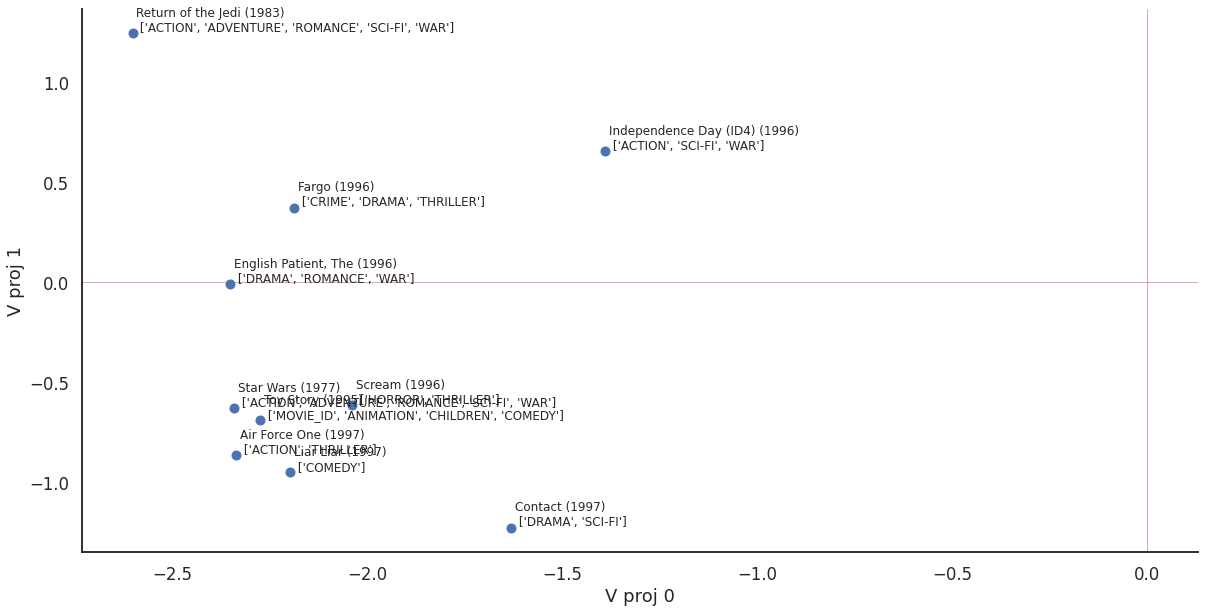

In [184]:
topn = 10
topn_pop_df = get_top_pop_movie_data(data, movies, topn)
list_movies_id = topn_pop_df.MOVIE_ID
list_movies_id = list(set(list_movies_id.to_list()))
print("Top most popular movies", list_movies_id)

(
    list_movies_id,
    list_movies_genre,
    list_movies_titles,
) = get_list_movies_from_list_of_ids(data, list_movies_id)

V_proj_selection = get_V_proj_selection(list_movies_id, V_proj)
visualize(V_proj_selection, list_movies_titles, list_movies_genre,'method1_partb.pdf')

#### c) Top best movies

Top best movies [408, 318, 169, 483, 114, 64, 603, 12, 50, 178]
How many times the movies were rated?  [108. 261. 109. 213.  63. 257. 183. 241. 527. 118.]
['Close Shave, A (1995)', "Schindler's List (1993)", 'Wrong Trousers, The (1993)', 'Casablanca (1942)', 'Wallace & Gromit: The Best of Aardman Animation (1996)', 'Shawshank Redemption, The (1994)', 'Rear Window (1954)', 'Usual Suspects, The (1995)', 'Star Wars (1977)', '12 Angry Men (1957)']


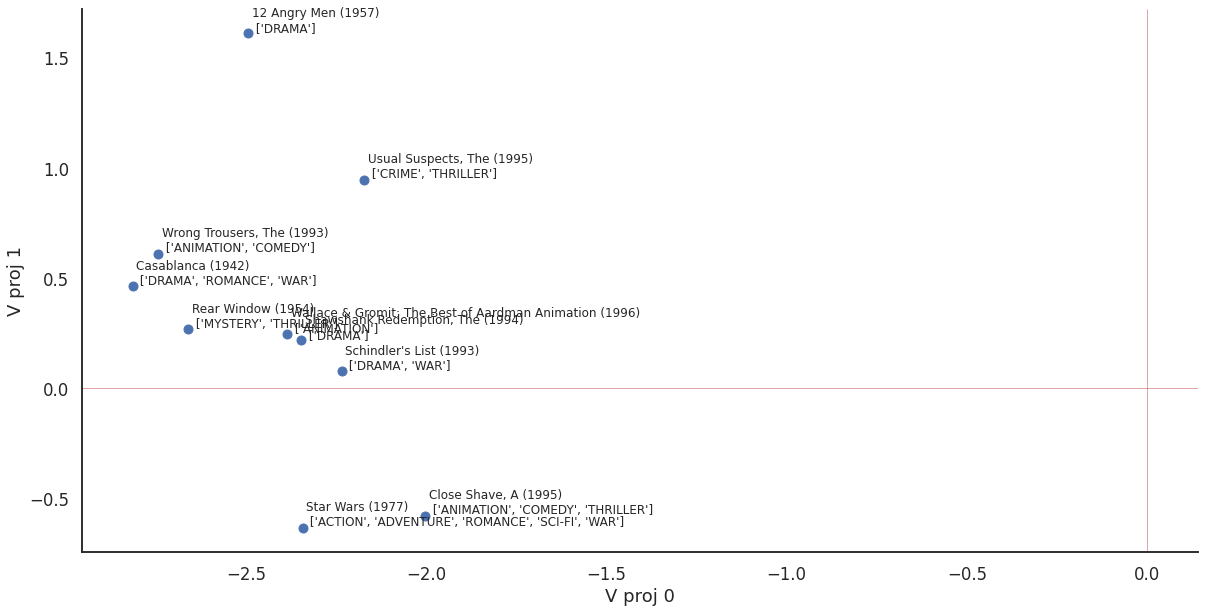

In [185]:
# hardcoded for now
list_movies_id = [408, 318, 169, 483, 114,  64, 603,  12,  50, 178]

print("Top best movies", list_movies_id)

(
    list_movies_id,
    list_movies_genre,
    list_movies_titles,
) = get_list_movies_from_list_of_ids(data, list_movies_id)




average_rating, ct = get_average_ratings_for_list_movies_ids(Y_train_df)
list_average_ratings = average_rating / ct
print("How many times the movies were rated? ", ct)

(
    list_movies_id,
    list_movies_genre,
    list_movies_titles,
) = get_list_movies_from_list_of_ids(data, list_movies_id)


V_proj_selection = get_V_proj_selection(list_movies_id, V_proj)
visualize(V_proj_selection, list_movies_titles, list_movies_genre,'method1_partc.pdf')


### Method 3: off-the-shelf implementation 

In [1]:
from surprise import SVD, Reader
import surprise
from surprise import Dataset
from surprise.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import sklearn

In [10]:
reader = Reader(rating_scale=(0,5))
train_dataset = Dataset.load_from_df(Y_train_df, reader)

train_dataset_object = train_dataset.build_full_trainset()

algo = SVD(n_factors=100, n_epochs=20)
cross_validate(algo, train_dataset, measures=['RMSE'], cv=5, verbose=True)

algo.fit(train_dataset_object)


Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9527  0.9491  0.9322  0.9300  0.9468  0.9422  0.0093  
Fit time          3.97    3.98    4.00    3.99    4.00    3.99    0.01    
Test time         0.10    0.18    0.10    0.09    0.09    0.11    0.03    


In [11]:
pred = []
for rows in Y_test_df.iterrows():
    uid = str(rows[1][0])
    iid = str(rows[1][1])
    rui = rows[1][2]

    # get a prediction for specific users and items.
    pred.append(algo.predict(uid, iid, r_ui=rui))

surprise.accuracy.rmse(pred)

RMSE: 1.1233


1.123264515751156

In [13]:
algo.pu.shape

(943, 100)

In [149]:
# utils fcns
def get_average_ratings_for_list_movies_ids(df):
    average_rating = np.zeros(len(list_movies_id))
    ct = np.zeros(len(list_movies_id))
    for rows in df.iterrows():
        for i, l in enumerate(list_movies_id):
            if rows[1][1] == l:
                average_rating[i] = average_rating[i] + rows[1][2]
                ct[i] += 1

    return average_rating, ct


#### Visualization 
#### a) Any ten movies of your choice from the MovieLens dataset.

How many times the movies were rated?  [ 12. 241.   5.  18.   1. 105.  96.  50.  42.   4.]
[103, 111, 1164, 1178, 957, 184, 682, 675, 674, 839]
['All Dogs Go to Heaven 2 (1996)', 'Truth About Cats & Dogs, The (1996)', 'Zeus and Roxanne (1997)', 'Major Payne (1994)', 'Pushing Hands (1992)', 'Army of Darkness (1993)', 'I Know What You Did Last Summer (1997)', 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)', 'Cat People (1982)', 'Loch Ness (1995)']


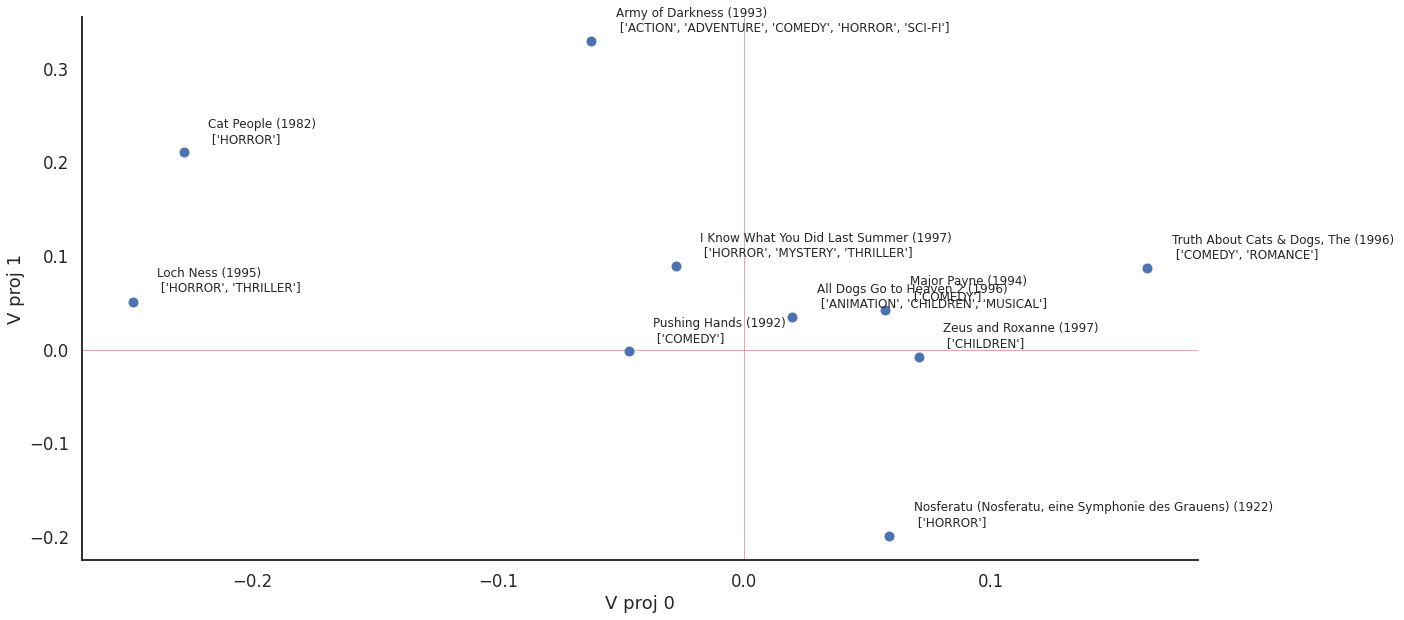

In [177]:
list_movies_id = [
    103,
    111,
    1164,
    (movies[movies["COMEDY"] == 1].sample()).MOVIE_ID.values[0],
    (movies[movies["COMEDY"] == 1].sample()).MOVIE_ID.values[0],
    (movies[movies["HORROR"] == 1].sample()).MOVIE_ID.values[0],
    (movies[movies["HORROR"] == 1].sample()).MOVIE_ID.values[0],
    (movies[movies["HORROR"] == 1].sample()).MOVIE_ID.values[0],
    (movies[movies["HORROR"] == 1].sample()).MOVIE_ID.values[0],
    (movies[movies["HORROR"] == 1].sample()).MOVIE_ID.values[0],
]

average_rating, ct = get_average_ratings_for_list_movies_ids(Y_train_df)
list_average_ratings = average_rating / ct
print("How many times the movies were rated? ", ct)

(
    list_movies_id,
    list_movies_genre,
    list_movies_titles,
) = get_list_movies_from_list_of_ids(data, list_movies_id)


print(list_movies_id)

A_two_cols = get_first_two_components_from_svd(algo.qi.transpose())
qi_proj = A_two_cols.transpose() @ algo.qi.transpose()  # U
pu_proj = A_two_cols.transpose() @ algo.pu.transpose()  # V


V_proj_selection = get_V_proj_selection(list_movies_id, qi_proj)
visualize(V_proj_selection, list_movies_titles, list_movies_genre, filename="method3_parta.pdf")

#### (b) The ten most popular movies (movies which have received the most ratings).

Top most popular movies [288, 1, 258, 100, 294, 300, 50, 181, 121, 286]
How many times the movies were rated?  [433. 411. 455. 457. 446. 386. 527. 455. 383. 425.]
['Scream (1996)', 'Toy Story (1995)', 'Contact (1997)', 'Fargo (1996)', 'Liar Liar (1997)', 'Air Force One (1997)', 'Star Wars (1977)', 'Return of the Jedi (1983)', 'Independence Day (ID4) (1996)', 'English Patient, The (1996)']


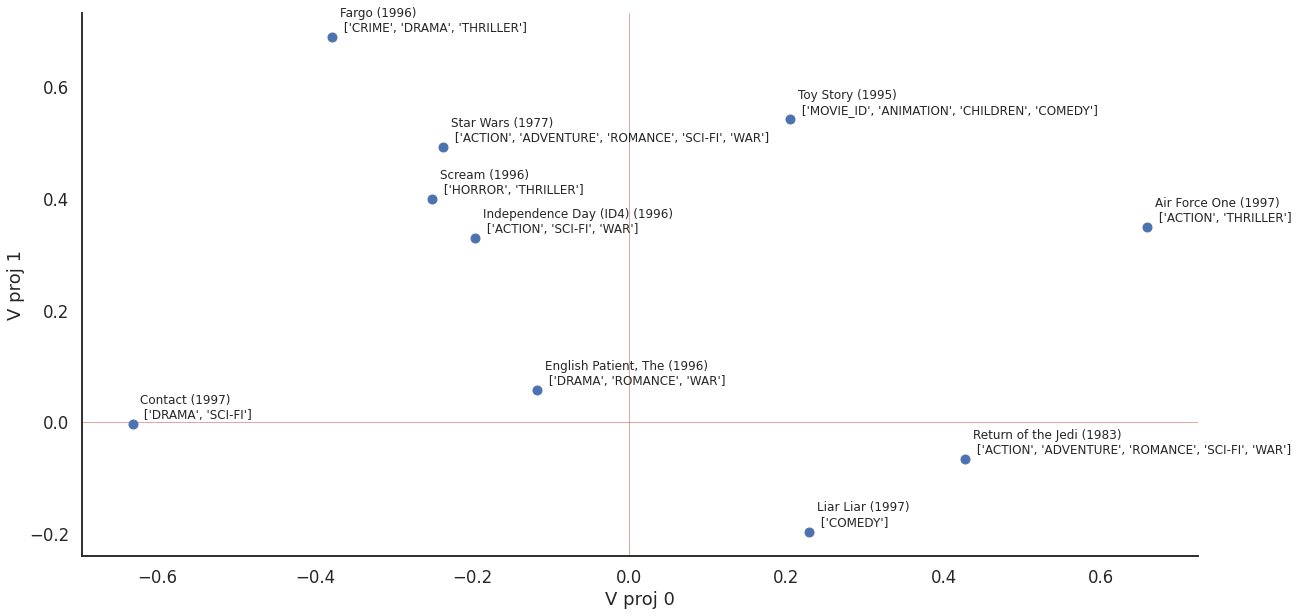

In [161]:
topn = 10
topn_pop_df = get_top_pop_movie_data(data, movies, topn)
list_movies_id = topn_pop_df.MOVIE_ID
list_movies_id = list(set(list_movies_id.to_list()))
print("Top most popular movies", list_movies_id)

(
    list_movies_id,
    list_movies_genre,
    list_movies_titles,
) = get_list_movies_from_list_of_ids(data, list_movies_id)




average_rating, ct = get_average_ratings_for_list_movies_ids(Y_train_df)
list_average_ratings = average_rating / ct
print("How many times the movies were rated? ", ct)

(
    list_movies_id,
    list_movies_genre,
    list_movies_titles,
) = get_list_movies_from_list_of_ids(data, list_movies_id)


V_proj_selection = get_V_proj_selection(list_movies_id, qi_proj)
visualize(V_proj_selection, list_movies_titles, list_movies_genre, "method3_partb.pdf")

In [152]:
### (c) The ten best movies (movies with the highest average ratings).

Top best movies [408, 318, 169, 483, 114, 64, 603, 12, 50, 178]
How many times the movies were rated?  [108. 261. 109. 213.  63. 257. 183. 241. 527. 118.]
['Close Shave, A (1995)', "Schindler's List (1993)", 'Wrong Trousers, The (1993)', 'Casablanca (1942)', 'Wallace & Gromit: The Best of Aardman Animation (1996)', 'Shawshank Redemption, The (1994)', 'Rear Window (1954)', 'Usual Suspects, The (1995)', 'Star Wars (1977)', '12 Angry Men (1957)']


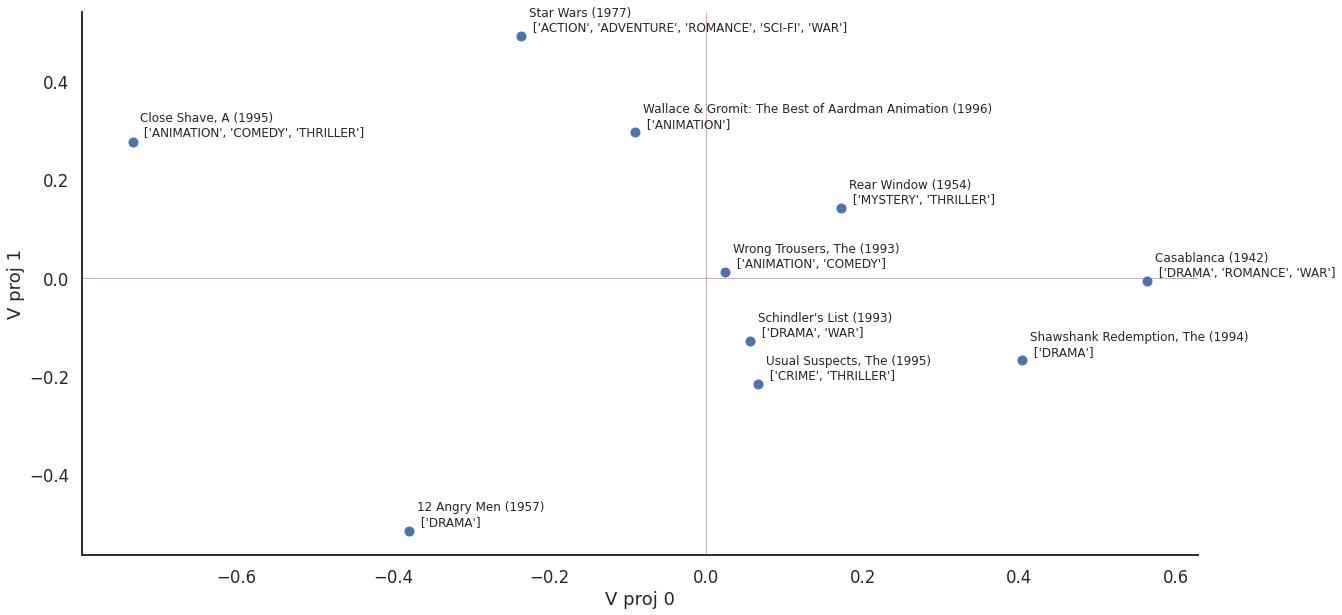

In [171]:
# hardcoded for now
list_movies_id = [408, 318, 169, 483, 114,  64, 603,  12,  50, 178]

print("Top best movies", list_movies_id)

(
    list_movies_id,
    list_movies_genre,
    list_movies_titles,
) = get_list_movies_from_list_of_ids(data, list_movies_id)




average_rating, ct = get_average_ratings_for_list_movies_ids(Y_train_df)
list_average_ratings = average_rating / ct
print("How many times the movies were rated? ", ct)

(
    list_movies_id,
    list_movies_genre,
    list_movies_titles,
) = get_list_movies_from_list_of_ids(data, list_movies_id)


V_proj_selection = get_V_proj_selection(list_movies_id, qi_proj)
visualize(V_proj_selection, list_movies_titles, list_movies_genre,"method3_partc.pdf")